## Can We Predict Life Expectancy Using Machine Learning?

**Exploring Machine Learning Techniques using Health and Economic data from the World Bank Databank**

In this notebook, we will try to assess whether a country’s life expectancy can be predicted based on a number of health and economic factors.

After conducting some research, we identified **four main factors** (listed below), and we will proceed by examining whether they can be used to create a robust predictive model.

The models we will be trying out are:

- **Linear Regression**
- **Decision Tree**
- **Random Forest**

The required data was sourced from the **World Bank Data Bank**.

To increase the number of samples, panel data was created using multiple years and countries for the analysis — **76 countries over the perio 2000–2020**.
20Please find below feature names and descriptions:

- **Time**: Years  
- **Country**
- **Country_code**: Country code  
- **Life_expectancy**: Life expectancy at birth, total (years)  
- **Fertility_rate**: Fertility rate, total (births per woman)  
- **greenhouse_gas_em**: Total greenhouse gas emissions (Mt CO2e)  
- **drinking_water**: People using at least basic drinking water services (% of population)  
- **health_expenditure**: Current health expenditure per capita (current US$)
 (current US$)
k.

#### Section 1 : EDA

In this section we will load the data and perform the following tasks:

- **Generate descriptive statistics**
- **Generate histograms to visualize data distributions**
- **Generate boxplots to check for outliers**
- **Generate correlation table to check the potential impact of each independent variable with the dependent**
- **Generate scatter plots to visualize the relationship of the independent variables with the dependent**

In [3]:
# import all neccessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error


In [80]:
# Spreadsheet ID from Google Sheet link
sheet_id = "1VaQnQkm6caPyqbgZN4s5URwPUQdTbngn"

# Sheet name
sheet_name = "Sheet1"

# Generate the csv export URL
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the sheet into a DataFrame
df = pd.read_csv(csv_url)

# Display the first few rows
df.head()


,Time,Country,Country_Code,Life_expectancy,fertility_rate,greenhouse_gas_em,drinking_water,health_expenditure
0,2000,Angola,AGO,46.02,6.64,107.086,41.14,13.00
1,2000,Australia,AUS,79.23,1.76,585.893,99.71,1636.53
2,2000,Belgium,BEL,77.72,1.67,149.470,100.00,1849.92
3,2000,Austria,AUT,78.13,1.36,66.810,100.00,2269.00
4,2000,Bangladesh,BGD,65.78,3.22,146.386,94.82,8.62


In [11]:
#Generate descriptive statistics for all nummeric variables
df.describe()

,Time,Life_expectancy,fertility_rate,greenhouse_gas_em,drinking_water,health_expenditure
count,1064.000000,1064.000000,1064.000000,1050.000000,1036.000000,1064.000000
mean,2009.500000,74.093083,2.230555,471.522318,93.167780,1564.227218
std,7.231815,7.556214,1.145930,1328.949160,11.598952,1990.404270
min,2000.000000,46.020000,1.080000,-47.348000,41.140000,8.420000
25%,2003.000000,71.175000,1.480000,32.948500,91.872500,131.087500
50%,2006.500000,75.805000,1.795000,87.239000,98.660000,628.015000
75%,2017.000000,79.460000,2.512500,382.748500,100.000000,2346.167500
max,2020.000000,84.560000,6.640000,13346.989000,100.000000,11758.420000


In [13]:
#assign features of interest to a new variable called "numeric_df"
#in order to create the corresponding histogramms and visualize the data distribution

numeric_df = df.drop(columns=['Time', 'Country', 'Country_Code'])
numeric_df.head()

,Life_expectancy,fertility_rate,greenhouse_gas_em,drinking_water,health_expenditure
0,46.02,6.64,107.086,41.14,13.00
1,79.23,1.76,585.893,99.71,1636.53
2,77.72,1.67,149.470,100.00,1849.92
3,78.13,1.36,66.810,100.00,2269.00
4,65.78,3.22,146.386,94.82,8.62


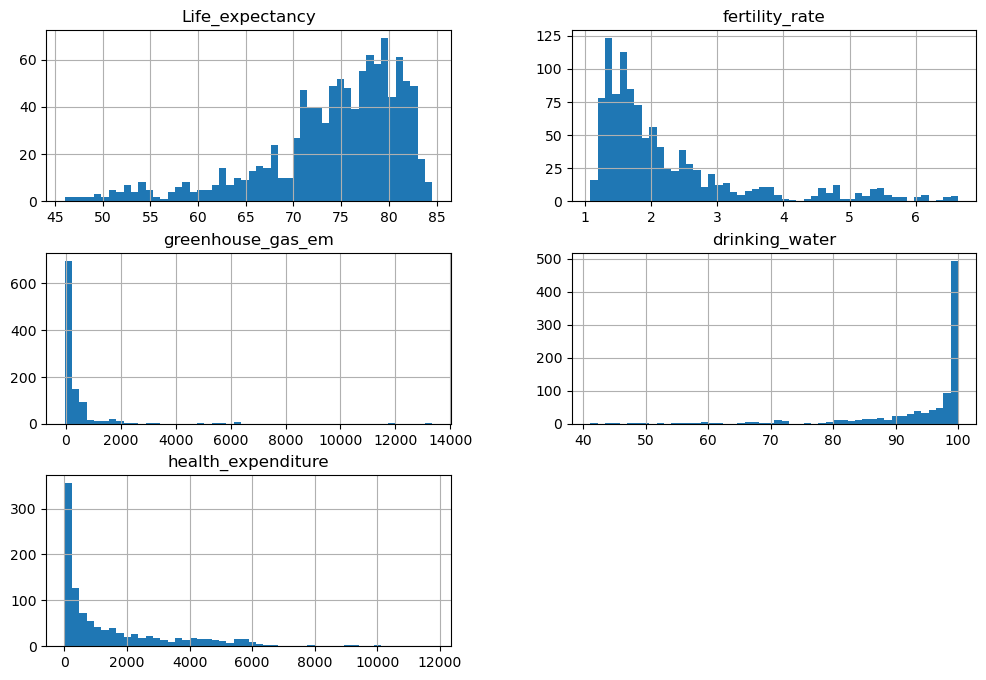

In [15]:
numeric_df.hist(bins=50, figsize=(12, 8))
plt.show()

As expected, based on the descriptive statistics and the histogramms we can confirm that both the dependent and the independent variables are skewed.

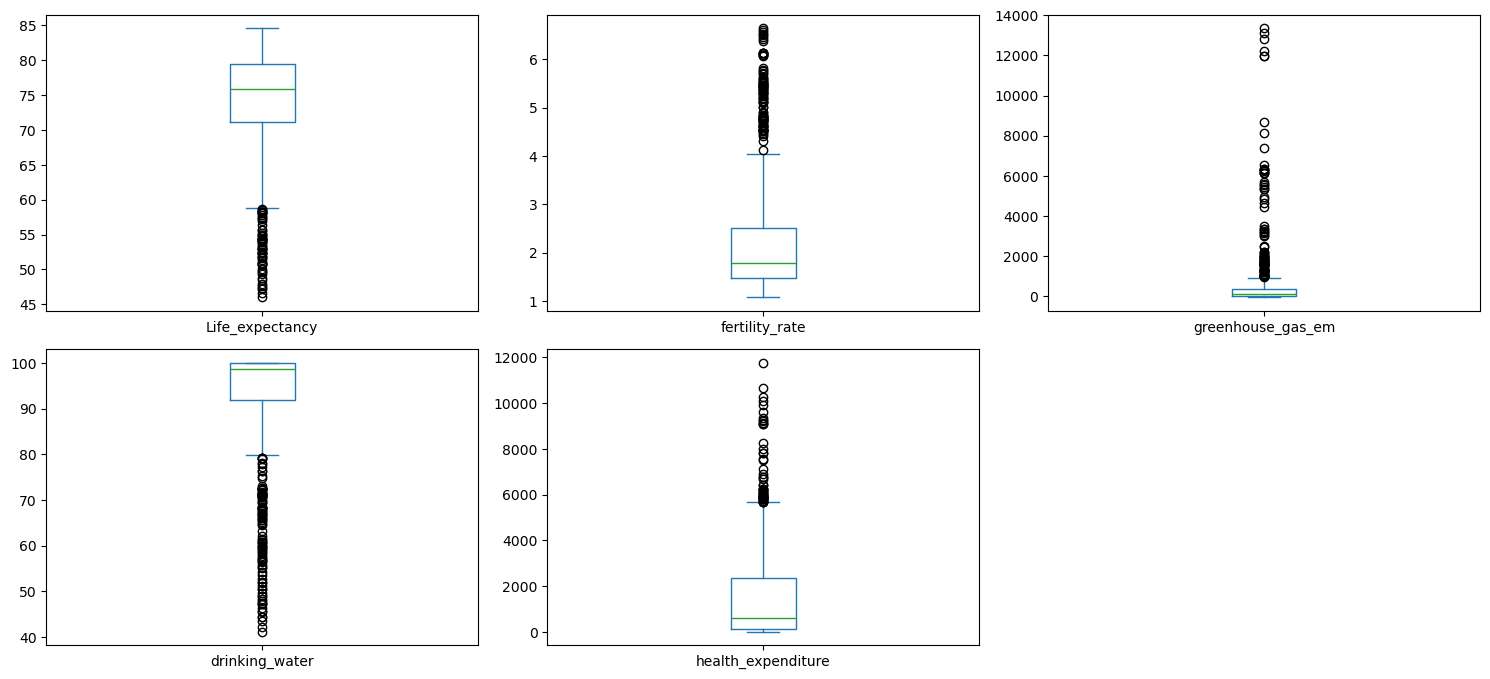

In [18]:
#next up, check for outliers!
numeric_df.plot(kind='box', subplots=True, layout=(len(df.columns)//3 + 1, 3), figsize=(15,10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

All of our features contain a lot of outliers. However, due to the limited size of our dataset I have decided not to discard them. Another reason to keep the outliers is that decision trees and random forests will not be greatly affected by them.

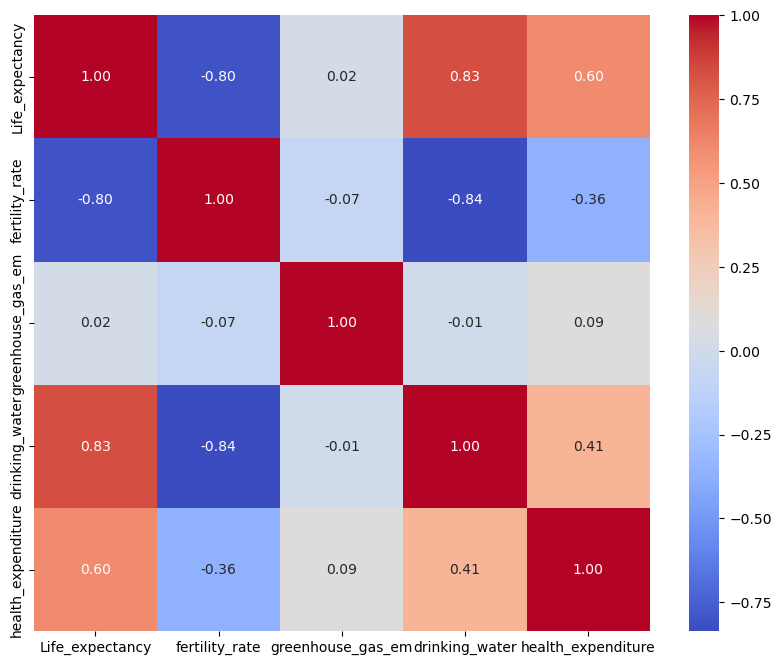

In [21]:
#Moving on with correlation!
# Compute the correlation matrix
corr = numeric_df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Show the plot
plt.show()

From the above correlation heatmap we spot a strong negative relationship of Life expectancy with the fertility rate.
On the other hand, we see a strong positive relationship with drinking water and health expenditure.
Strangely enough, greenhouse gas emitions do not seem to have much of an impact on our dependent variable!

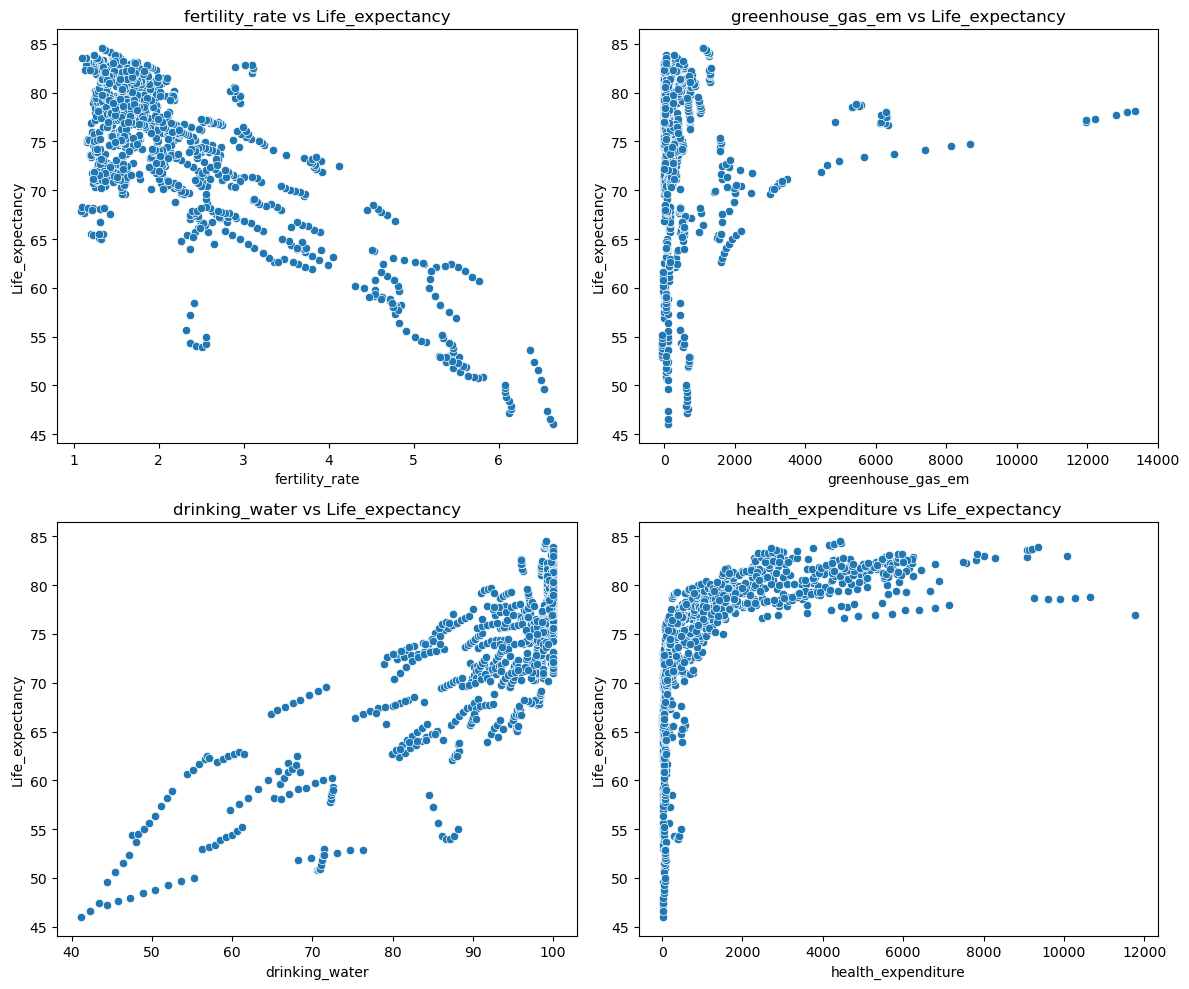

In [24]:
#Let's make some scatterplots as well

#Assign values to our independent and dependent variables
independent_vars = ["fertility_rate", "greenhouse_gas_em", "drinking_water","health_expenditure" ]
dependent_var = "Life_expectancy"

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each scatter plot using a for loop
for i, var in enumerate(independent_vars):
    sns.scatterplot(data=numeric_df, x=var, y=dependent_var, ax=axes[i])
    axes[i].set_title(f'{var} vs {dependent_var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(dependent_var)

plt.tight_layout()
plt.show()

The above plots show a linear relationship of our dependent variable with both the drinking water (positive) and the fertility rate (negative).
Health expenditure's relationship with Life expectancy is not quite linear (although positive) and finally we cannot see a clear relationship for the greenhouse gas emissions.

#### Section 2 : Data preprocessing

Based on our findings from Section 1 I decided to:

- **Keep the outliers for the modeling section**
- **Add an extra column in order to split Life expectancy into 3 categories**
   - Category 1 : Life expectancy greater than 80 years (value assigned : 1)
   - Category 2 : Life expectancy less or equal to 80 and greater than 70 (2)
   - Category 3 : Life expectancy less or equal to 70 years (3)

Additionally, in this section we will perform the following tasks:

- **Check and handle missing values**
- **Check and handle data types**
- **Add/drop columns for the needs of our models**

In [28]:
#Add an extra feature based on the aforementioned categories
life = df["Life_expectancy"]

df.loc[life <= 70,  "class"] = 3
df.loc[((life > 70) & (life <= 80))  , "class"] = 2
df.loc[life > 80, "class"] = 1

df.head()

,Time,Country,Country_Code,Life_expectancy,fertility_rate,greenhouse_gas_em,drinking_water,health_expenditure,class
0,2000,Angola,AGO,46.02,6.64,107.086,41.14,13.00,3.0
1,2000,Australia,AUS,79.23,1.76,585.893,99.71,1636.53,2.0
2,2000,Belgium,BEL,77.72,1.67,149.470,100.00,1849.92,2.0
3,2000,Austria,AUT,78.13,1.36,66.810,100.00,2269.00,2.0
4,2000,Bangladesh,BGD,65.78,3.22,146.386,94.82,8.62,3.0


In [30]:
#Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                1064 non-null   int64  
 1   Country             1064 non-null   object 
 2   Country_Code        1064 non-null   object 
 3   Life_expectancy     1064 non-null   float64
 4   fertility_rate      1064 non-null   float64
 5   greenhouse_gas_em   1050 non-null   float64
 6   drinking_water      1036 non-null   float64
 7   health_expenditure  1064 non-null   float64
 8   class               1064 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 74.9+ KB


In [32]:
#change the datatype of class to integer in order for the classification algorithms to run smoothly
df["class"] = df["class"].astype(int)

In [34]:
#Check the percentage of missing values from the dataset
df.isnull().mean() * 100

Time                  0.000000
Country               0.000000
Country_Code          0.000000
Life_expectancy       0.000000
fertility_rate        0.000000
greenhouse_gas_em     1.315789
drinking_water        2.631579
health_expenditure    0.000000
class                 0.000000
dtype: float64

As we have a limited number of samples (1064) and the missing data of the features greenhouse_gas_em and drinking water are below 3% of the total, I decided to discard them from our dataset. Another reason I decided not to proceed with data imputation (ex. mean, median etc.) is to not alter the data distribution of those attributes.

In [37]:
#the updated dataset will be assigned for convenience to the new variable 'df_2'
df_2 = df.dropna()

#### Section 3 : Predictive Modeling

Based on our findings from the EDA we will exclude the greenhouse gas emissions and keep the below independent variables for our predictive models:

- **Fertility_rate**   
- **drinking_water** 
- **health_expenditure**

We will proceed by spliting our data into a training and a test set.
After that, we will train and test a Linear Regression, a Decision Tree and a Random Forest model.



In [40]:
#train, test split
X = df_2[["fertility_rate", "drinking_water","health_expenditure"]]
y = df_2["Life_expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
#train our linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [44]:
#fit the model into the training and the testing data
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

In [46]:
#generate the root mean squared error for both sets of data
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test =  root_mean_squared_error(y_test, y_pred_test)

print(rmse_train,' ' , rmse_test)

3.3011322066092044   3.5393259253865996


I used the root mean squared error as the first accuracy metric of the Linear regression. With this metric we can assess the quality of the predictions that our model generates as it is the average magnitude of the errors between predicted and actual values. It is expressed in metric units of our dependent variable (3,5 years for the test set and 3.3 years for the training set)

In [49]:
#generate the R2 score for our data
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(r2_train,' ' , r2_test)

0.8092649917347867   0.8102321279448272


The R2 score show how well our model fits the data. We can therefore see how much of the variance of the dependent variable is explained by this Linear regression (In our case almost 81% for the training data and a bit above 81% for the testing data)

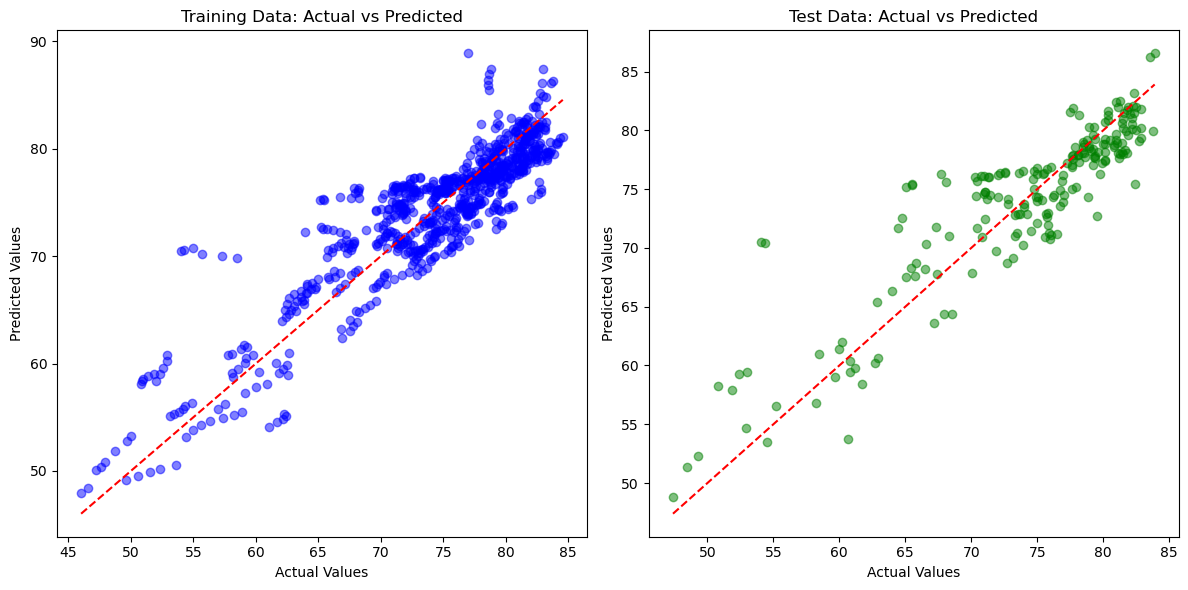

In [52]:
#Let's plot all this info into a graph in order to visualize it!

# Scatter plot for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Scatter plot for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

Based on the above metrics and graphs we see that our model is on the right track but still has room for improvement as it fails to capture accurately the variance of Life expectancy.

Let's standardize our independent variables to see if the model improves.

The process consists of rescaling the data so that it has zero mean and fits under a mormal curve.

In [56]:
X = df_2[["fertility_rate", "drinking_water","health_expenditure"]]
y = df_2["Life_expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Scale the data and retrain the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [58]:
#get rmse and R2 for the test set

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# R2 Score
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


R² Score: 0.8102321279448277
RMSE: 3.5393259253865947


Unfortunately, standardization did not improve much our model as both rmse and r2 remained almost the same as before.

A lot more can be done to improve the model but for the purposes of this project we will be moving on to classification algorithms

In [61]:
#Let's proceed by training and testing a Decision Tree Classifier
X = df_2[["fertility_rate", "drinking_water","health_expenditure"]]
y = df_2["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = DecisionTreeClassifier(max_depth=5, random_state=13)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=13)

In [63]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [65]:
#get the accuracy score for both the training and the test set
acc_train = accuracy_score(y_pred_train, y_train)
acc_test = accuracy_score(y_pred_test, y_test)
print(acc_train)
print(acc_test)

0.8910648714810282
0.8292682926829268


The accuracy score shows promising results allowing us to move on to our Random Forest model.
In brief, this score shows the proportion of correct predictions made by our model compared to the total number of predictions.

In [68]:
#Train and test a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
f_pred_train = rf_model.predict(X_train)
f_pred_test = rf_model.predict(X_test)

acc_train = accuracy_score(f_pred_train, y_train)
acc_test = accuracy_score(f_pred_test, y_test)
print(acc_train)
print(acc_test)

1.0
0.8878048780487805


In [72]:
#generate a classification report
print("\nClassification Report:\n", classification_report(y_test, f_pred_test))


Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.80      0.85        51
           2       0.86      0.94      0.90       109
           3       0.95      0.87      0.91        45

    accuracy                           0.89       205
   macro avg       0.90      0.87      0.88       205
weighted avg       0.89      0.89      0.89       205



The results of the classification look promising! Let's break them down :
- **Precision**: The proportion of true positive predictions out of all positive predictions made by the model.
- **Recall**: The proportion of true positive predictions out of all actual positives in the data.
- **F1-score**: The harmonic mean of precision and recall, balancing the two.

Last but not least let's generate a confusion matrix in order to better visualize our findings.

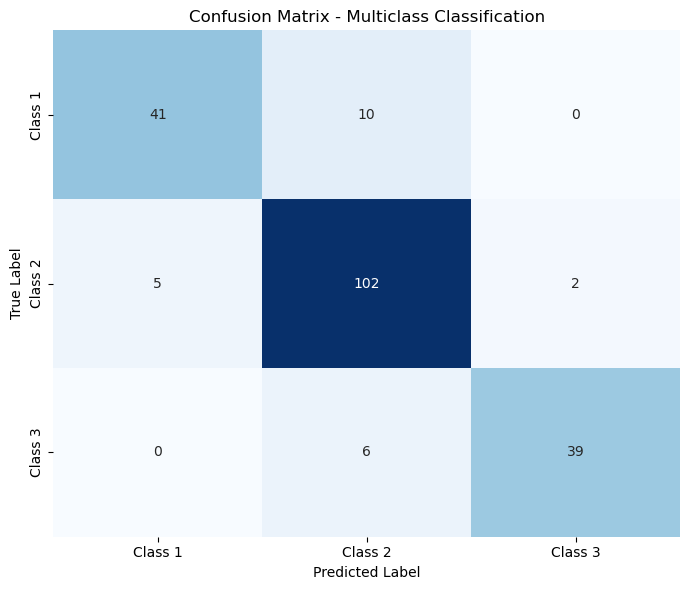

In [76]:
# Confusion Matrix
cm = confusion_matrix(y_test, f_pred_test)

# Plot with seaborn
plt.figure(figsize=(7, 6))
class_labels = ['Class 1', 'Class 2', 'Class 3']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Multiclass Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

The above confusion matrix shows that our model does a good job in accurately classifying Life Expectancy as class 2.
Out of 109 class 2 samples our model correctly classified 101.

Following the same logic we can interpet the results for classes 1 and 3.

#### Section 4 : Conclusion and Results

**Summary of Findings:**

- While the Linear Regression model successfully identified the overall trend, it did not provide accurate predictions for Life Expectancy.

- In contrast, classification models demonstrated stronger performance and show potential for practical application.

For instance, the Random Forest classification model could be employed to predict Life Expectancy categories across various countries. If a country is classified into categories 2 or 3, it could signal the need for targeted governmental interventions—such as increasing healthcare expenditure and enhancing infrastructure to improve access to clean drinking water for a larger portion, if not the entirety, of the population.